# **<center><font style="color:rgb(100,109,254)">Module 1: Creating a Live Gesture Control Application</font> </center>**

<img src='https://drive.google.com/uc?export=download&id=10xY6U-4CecBuMkbONZp6bPx7BAZB6xfX'>

## **<font style="color:rgb(134,19,348)"> Module Outline </font>**

The module can be split into the following parts:

- *Lesson 1: Introduction to hand landmark detection theory*

- *Lesson 2:* Create a Hands Landmarks Detector

- *Lesson 3:* Build a Hands Fingers Counter

- *Lesson 4:* Build a Hand Gesture Recognizer 

- ***Lesson 5:* Distance measurement** *(This Tutorial)*

- *Lesson 6:* Brightness, Saturation, Contrast Enhancement & Gamma Correction

- *Lesson 7:* Build the Final Application

**Please Note**, these Jupyter Notebooks are not for sharing; do read the Copyright message below the Code License Agreement section which is in the last cell of this notebook.
-Taha Anwar

Alright, let's get started.

In [1]:
import cv2
import math
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from previous_lesson import detectHandsLandmarks, countFingers

## **<font style="color:rgb(134,19,348)">Initialize the Hands Landmarks Detection Model</font>**

After that, we will need to initialize the **`mp.solutions.hands`** class and then set up the **`mp.solutions.hands.Hands()`** function with appropriate arguments and also initialize **`mp.solutions.drawing_utils`** class that is required to visualize the detected landmarks, as we have been doing in the previous lessons.

In [2]:
# Initialize the mediapipe hands class.
mp_hands = mp.solutions.hands

# Set up the Hands functions for images and videos.
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)
hands_videos = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.8)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils

## **<font style="color:rgb(134,19,348)">Create a Calculate Distance Function</font>**

Now We will create a function that will simply calculate the distance between two points on an image using the function [**`math.hypot()`**](https://docs.python.org/3/library/math.html#math.hypot). We will also draw circles using the function [**`cv2.circle()`**](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670) on the two points and a line joining the two points with the help of the function [**`cv2.line()`**](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#ga7078a9fae8c7e7d13d24dac2520ae4a2).

In [3]:
def calculateDistance(image, point1, point2, draw=True, display=True):
    '''
    This function will calculate distance between two points on an image.
    Args:
        image:   The image on which the two points are.
        point1:  A point with x and y coordinates values on the image.
        point2:  Another point with x and y coordinates values on the image.
        draw:    A boolean value that is if set to true the function draws a line between the 
                 points and write the calculated distance on the image
        display: A boolean value that is if set to true the function displays the output image 
                 and returns nothing.
    Returns:
        distance: The calculated distance between the two points.
        
    '''
    
    # Initialize the value of the distance variable.
    distance = None
    
    # Get the x and y coordinates of the points.
    x1, y1 = point1
    x2, y2 = point2
    
    # Check if all the coordinates values are processable.
    if isinstance(x1, int) and isinstance(y1, int) \
    and isinstance(x2, int) and isinstance(y2, int):
        
        # Calculate the distance between the two points.
        distance = math.hypot(x2 - x1, y2 - y1)
        
        # Check if the distance is greater than the upper threshold.
        if distance > 230:
            
            # Set the distance to the upper threshold.
            distance = 230
        
        # Check if the distance is lesser than the lower threshold.
        elif distance < 30:
            
             # Set the distance to the lower threshold.
            distance = 30
            
        if draw:

            # Draw a line between the two points on the image. 
            cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)),
                     (255, 0, 255), 4)

            # Draw a circle on the first point on the image.
            cv2.circle(image, (int(x1), int(y1)), 20, (0, 255, 0), -1)

            # Draw a circle on the second point on the image.
            cv2.circle(image, (int(x2), int(y2)), 20, (0, 255, 0), -1)

            # Write the calculated distance between the two points on the image.
            cv2.putText(image, f'Distance: {round(distance, 2)}', (10, 30), 
                        cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 2)
            
    # Check if the image is specified to be displayed.
    if display:
        
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Return the calculated distance.
    return distance

Now we will check if the function **`calculateDistance()`** created above, is working or not, by calculating the distance between two points on a few sample images.

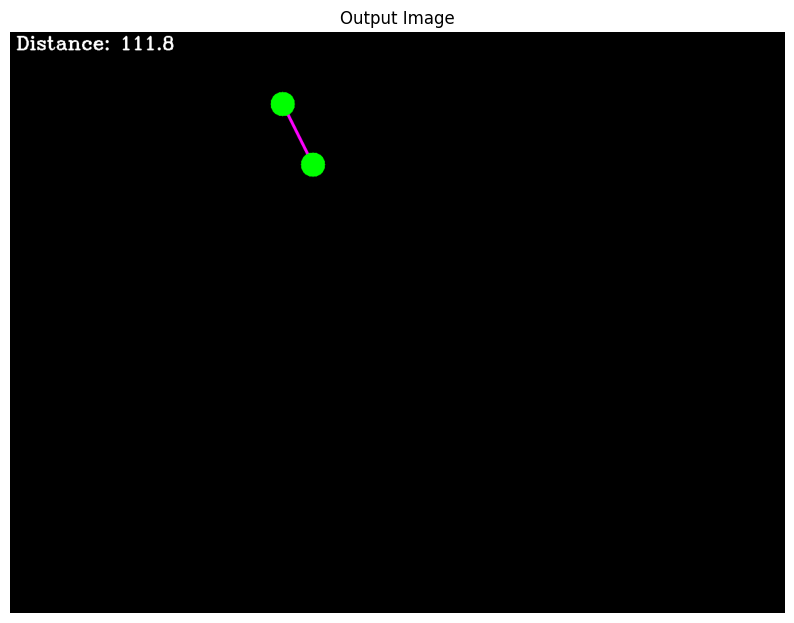

In [4]:
# Calculate the distance between two points and display the results.
image = np.zeros((960, 1280, 3), np.uint8)
distance = calculateDistance(image, point1=(450,120), point2=(500,220))

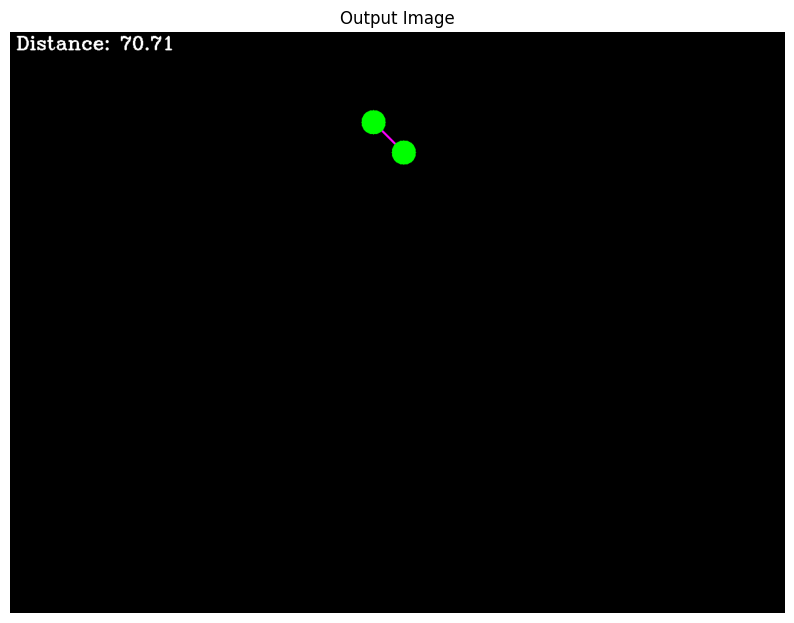

In [5]:
# Calculate the distance between two points and display the results.
image = np.zeros((960, 1280, 3), np.uint8)
distance = calculateDistance(image, point1=(600,150), point2=(650,200))

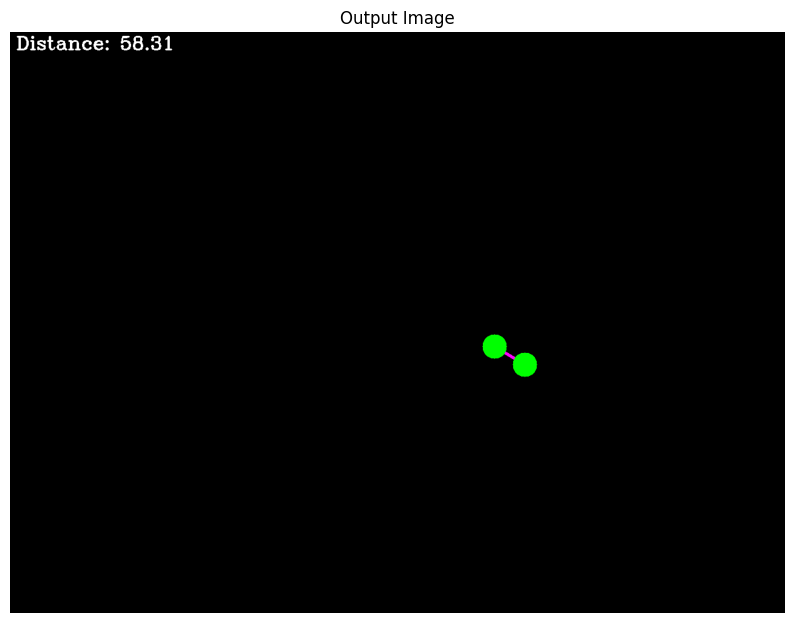

In [6]:
# Calculate the distance between two points and display the results.
image = np.zeros((960, 1280, 3), np.uint8)
distance = calculateDistance(image, point1=(800,520), point2=(850,550))

Working fine! Now lets test it on real-time webcam feed to calculate distance between the tips of the `MIDDLE` finger and the `THUMB` of the right hand. We will use the function **`countFingers()`**, from a previous tutorial to get the tips landmarks of the fingers. We will also draw a bar (rectangle) on the frame whose height will increase/decrease in real-time with the increase/decrease of the distance between the fingers. For this, we will use the [**`scipy.interpolate.interp1d()`**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) function to get the height of the bar (rectangle) based on the current distance.

In [7]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Distance Measurement', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
        
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Perform Hands landmarks detection on the frame.
    frame, results = detectHandsLandmarks(frame, hands_videos, display=False)
    
    # Check if the hands landmarks in the frame are detected.
    if results.multi_hand_landmarks:
        
        # Get the tips landmarks of the detected hand(s).
        _, _, fingers_tips_position = countFingers(frame, results,
                                                   draw=False, display=False)
        
        # Get the tips landmarks of the right hand.
        size_gesture_tip_pts = fingers_tips_position['RIGHT']
        
        # Calculate the distance between the right hand middle finger tip and thumb tip landmark of the right hand.
        distance = calculateDistance(frame, size_gesture_tip_pts['MIDDLE'],
                                     size_gesture_tip_pts['THUMB'], display=False)
        
        # Check if the distance is calculated successfully.
        if distance:
        
            # Get the interpolation function and calculate the bar value.
            # This will be used to draw a filled rectangle of height varying with the distance.
            bar_interp_f = interp1d([30,230],  [frame_height-50, frame_height-400])
            bar_value = bar_interp_f(distance) 

            # Draw the filled rectangle with varying height on the frame.
            cv2.rectangle(frame, (frame_width-80, int(bar_value)), 
                          (frame_width-50, frame_height-50), (255, 0, 255), -1)

            # Draw another rectangle around the filled rectangle on the frame.
            cv2.rectangle(frame, (frame_width-80, frame_height-400),
                          (frame_width-50, frame_height-50), (0, 255, 0), 6)
                
    # Display the frame.
    cv2.imshow('Distance Measurement', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()


# Additional comments:
#           - To sum it up, this program will use the tip of
#             the thumb and middle finger. Using the x, y
#             coordinates of these landmarks, the difference
#             will be calculated. And that difference is used
#             to update the bar on the right side, and the 
#             exact disctance counter on top left.
#           - Furthermore, some clips were added so that when
#             the distance exceeds the desired range, it will
#             be set to the treshold.

Great! working as expected.

### **<font style="color:rgb(255,140,0)"> Code License Agreement </font>**
```
Copyright (c) 2022 Bleedai.com

Feel free to use this code for your own projects commercial or noncommercial, these projects can be Research-based, just for fun, for-profit, or even Education with the exception that you’re not going to use it for developing a course, book, guide, or any other educational products.

Under *NO CONDITION OR CIRCUMSTANCE* you may use this code for your own paid educational or self-promotional ventures without written consent from Taha Anwar (BleedAI.com).

```
